In [4]:
from sklearn.cross_decomposition import CCA
import numpy as np
import pickle
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from scipy.stats import zscore

import sys
sys.path.insert(0, '../SAC/')
import kinematics_preprocessing_specs

import config

parser = config.config_parser()
args, unknown = parser.parse_known_args()

In [5]:
#Load the test data of nusim

with open('../test_data/test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)
    
print(test_data.keys())

dict_keys(['emg', 'rnn_activity', 'rnn_input', 'rnn_input_fp', 'kinematics_mbodies', 'kinematics_mtargets'])


In [6]:
#Get the timepoints of each condition per cycle
with open('../kinematics_data/kinematics.pkl', 'rb') as file:
    kin_train_test = pickle.load(file)
    
kin_train = kin_train_test['train']
kin_test = kin_train_test['test']

#First update the keys of self.kin_test
for cond in range(len(kin_test)):
    kin_test[len(kin_train) + cond] = kin_test.pop(cond)
    
kin = kin_train
kin.update(kin_test)

In [8]:
#Get the experimental neural data

with open('../nusim_neural_data/neural_activity_train.pkl', 'rb') as file:
    neural_train = pickle.load(file)

with open('../nusim_neural_data/neural_activity_test.pkl', 'rb') as file:
    neural_test = pickle.load(file)

#First update the keys of self.kin_test
for cond in range(len(neural_test)):
    neural_test[len(neural_train) + cond] = neural_test.pop(cond)
    
neural = neural_train
neural.update(neural_test)

In [12]:
conds = [kin[cond].shape[-1] for cond in range(len(kin))]
total_conds = len(conds)

#Select the cycle for each condition (training conditions followed by testing): 0 for 1st cycle and so on
#The number of elements should be equal to num_train_conditions + num_test_conditions
cycles = [2, 2, 2, 2, 2, 2]

#Number of fixedsteps in the start of each condition
n_fixedsteps= args.n_fixedsteps

In [14]:
#index of conds to include in the CCA analysis
conds_analysis= [0, 1, 2, 3, 4, 5]

In [16]:
test_data.keys()
test_data['rnn_activity'][0].shape

(6000, 256)

In [18]:
#Load the network activities
A_agent = []

for idx, cond_activity in test_data['rnn_activity'].items():
    act_agent = cond_activity
    act_agent = act_agent[n_fixedsteps + cycles[idx] * conds[idx] : n_fixedsteps + (cycles[idx]+1) * conds[idx]]
    print(act_agent.shape)
    A_agent.append(act_agent[:, :])

(702, 256)
(803, 256)
(932, 256)
(1319, 256)
(619, 256)
(1106, 256)


In [20]:
# Load the experimental neural activities
A_exp = []
for cond in range(len(neural)):
    act_exp = neural[cond]
    print(act_exp.shape)
    A_exp.append(act_exp)

(702, 49)
(803, 49)
(932, 49)
(1319, 49)
(619, 49)
(1106, 49)


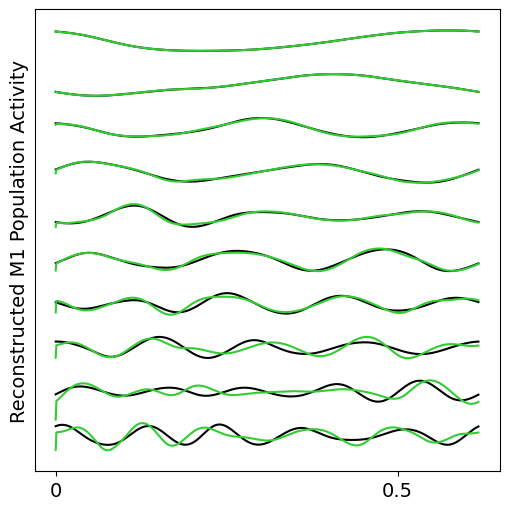

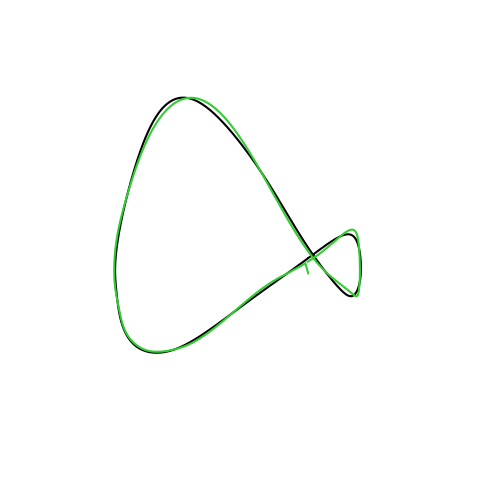

Now printing the correlations
CC1 R2 0.9999417354761132
CC2 R2 0.9998233971556131
CC3 R2 0.9941053514696421
CC4 R2 0.9915068247403939
CC5 R2 0.9606838910516341
CC6 R2 0.9617022414092647
CC7 R2 0.8732539089491249
CC8 R2 0.5045841027828407
CC9 R2 0.03663060499912696
CC10 R2 0.40687667268599514
Average R2 [Agent Canonical Activity transformed in Exp PC Space] 0.7729108730719749


In [22]:
#Select the condition to do the CCA
#Test Conditions are followed by Train conditions
cond = 4

A_exp_cca = A_exp[cond]
A_agent_cca = A_agent[cond]

#Select the number of components for PCA and CCA
n_comps = 10
PC_agent = PCA(n_components= n_comps)
PC_exp = PCA(n_components= n_comps)

A_exp_cca = PC_exp.fit_transform(A_exp_cca)
A_agent_cca = PC_agent.fit_transform(A_agent_cca)

cca = CCA(n_components =n_comps, scale= True)
exp_c, agent_c = cca.fit_transform(A_exp_cca, A_agent_cca)
# print(cca.score(A_exp_cca, A_agent_cca))

#Transform the canonical agent's activity back into the original experimental PC space
exp_prime = cca.inverse_transform(agent_c)

plt.figure(figsize= (6, 6))

for k in range(n_comps):
    if k==0:
        plt.plot(A_exp_cca[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth=1.5, c = 'k')
        plt.plot(exp_prime[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth= 1.5, c=(50/255, 205/255, 50/255), label= 'Network Reconstruction')
    else:
        plt.plot(A_exp_cca[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c='k')
        plt.plot(exp_prime[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c=(50 / 255, 205 / 255, 50 / 255))

plt.ylabel('Reconstructed M1 Population Activity', size=14)
plt.xticks([0, 500], ['0', '0.5'], size= 14)
plt.yticks([])
plt.show()

#Now plot the PCs on the same plot here
ax = plt.figure(figsize= (6,6), dpi=100).add_subplot(projection='3d')
ax.plot(A_exp_cca[:,0], A_exp_cca[:, 1], A_exp_cca[:, 2], c = 'k')
ax.plot(exp_prime[:,0], exp_prime[:, 1], exp_prime[:, 2], c=(50/255, 205/255, 50/255))

# Hide grid lines
ax.grid(False)
plt.grid(b=None)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.show()
# plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/PCA_619.svg', format='svg', dpi=300, transparent= True)


print('Now printing the correlations')

for comp in range(n_comps):
    print(f'CC{comp+1} R2', r2_score(A_exp_cca[:, comp], exp_prime[:, comp]))

sum = 0
for k in range(n_comps):
    sum = sum + r2_score(A_exp_cca[:, k], exp_prime[:, k])
average = sum / n_comps;

print('Average R2 [Agent Canonical Activity transformed in Exp PC Space]', average)

In [23]:
#Now do the CCA by transforming the experimental activity into agent's population space
#Transform the canonical experimental activity into the agent's population space
agent_prime = exp_c @ np.linalg.inv(cca.y_weights_)
agent_prime = agent_prime * np.std(A_agent_cca, axis= 0) + np.mean(A_agent_cca, axis= 0)

#Plot the R2 between the transform exp_canonical and agent population activity
sum = 0
for k in range(n_comps):
    print(f'CC{k+1} R2', r2_score(A_agent_cca[:, k], agent_prime[:, k]))
    
    sum = sum + r2_score(A_agent_cca[:, k], agent_prime[:, k])
average = sum / n_comps;

#The agent's population/pca activity as explained by the inverse CCA experimental activity
print('Average R2 [Exp Canonical Activity transformed in Agent PC Space]', average)

CC1 R2 0.9998163340099553
CC2 R2 0.9998093951285697
CC3 R2 0.9989969009453031
CC4 R2 0.9993904605921102
CC5 R2 0.9830484204834516
CC6 R2 0.8593153343707443
CC7 R2 0.9127135681879347
CC8 R2 0.8712794490606389
CC9 R2 0.39053023591114333
CC10 R2 -0.28396315318036636
Average R2 [Exp Canonical Activity transformed in Agent PC Space] 0.7730936945509486


In [26]:
#Now find the explained variance ratio of the agent population/PC subspace

A_agent_z = (A_agent_cca - np.mean(A_agent_cca, axis= 0)) / np.std(A_agent_cca, axis= 0)
# A_agent_z = zscore(A_agent_cca, ddof= 1 )
A_agent_zm = A_agent_z - np.mean(A_agent_z, axis= 0)

#Find the covariance matrix of the agent population/pca activity
C_agent = (A_agent_zm.T@A_agent_zm)/(A_agent_zm.shape[0]-1)

variance_explained= 0
for comp in range(n_comps):
    explained_variance_ratio = (cca.y_weights_[:, comp]@C_agent@cca.y_weights_[:, comp].T)/np.sum(np.diag(C_agent))
    variance_explained += explained_variance_ratio
    print(f'Variance explained by CC{comp+1}' , explained_variance_ratio)

print('Variance Explained', variance_explained)

Variance explained by CC1 0.10000008101220005
Variance explained by CC2 0.09999999122021541
Variance explained by CC3 0.09999997879076952
Variance explained by CC4 0.10000001650055244
Variance explained by CC5 0.09999996082336299
Variance explained by CC6 0.10000003112736336
Variance explained by CC7 0.09999999721435403
Variance explained by CC8 0.10000007194643734
Variance explained by CC9 0.10000000139500595
Variance explained by CC10 0.10000000088815532
Variance Explained 1.0000001309184166


In [28]:
#Concatenate the musim activity for all conditions
for idx_cond, i_cond in enumerate(conds_analysis):
    
    if idx_cond == 0:
        A_agent_cum = A_agent[i_cond]
    else:
        A_agent_cum = np.concatenate((A_agent_cum, A_agent[i_cond]), axis=0)
        
#Concatenate the experimental neural activity for all conditions
for idx_cond, i_cond in enumerate(conds_analysis):
    if idx_cond == 0:
        A_exp_cum = A_exp[i_cond]
    else:
        A_exp_cum = np.concatenate((A_exp_cum, A_exp[i_cond]), axis=0)
        
print(A_agent_cum.shape)
print(A_exp_cum.shape)

(5481, 256)
(5481, 49)


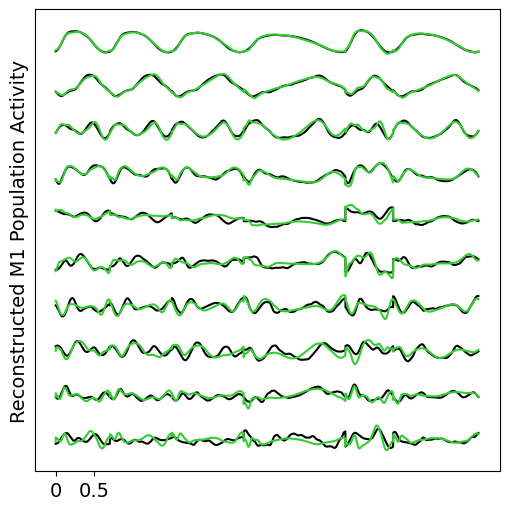

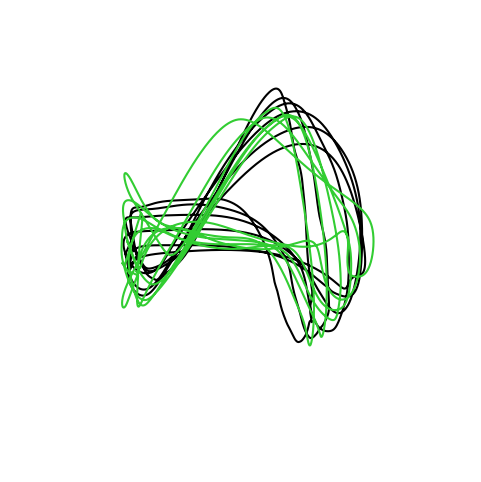

Now printing the correlations
CC1 R2 0.9940794074687781
CC2 R2 0.9712244868352827
CC3 R2 0.8913982020889264
CC4 R2 0.9160541386722364
CC5 R2 0.6247850750794187
CC6 R2 0.6149755237871313
CC7 R2 0.5829769170100245
CC8 R2 0.32441558152850514
CC9 R2 0.4401373802111539
CC10 R2 -0.26824738936985626
Average R2 (Combined) [Agent Canonical Activity transformed in Exp PC Space] 0.6091799323311602


In [30]:
#Do the collective CCA for all the speeds

A_exp_cca = A_exp_cum
A_agent_cca = A_agent_cum

#Filter the agent's activity through 20ms gaussian filter as done with experimental data
# A_agent_cca = gaussian_filter1d(A_agent_cca.T, 20).T

#Select the number of components for PCA and CCA
n_comps = 10
PC_agent = PCA(n_components= n_comps)
PC_exp = PCA(n_components= n_comps)

A_exp_cca = PC_exp.fit_transform(A_exp_cca)
A_agent_cca = PC_agent.fit_transform(A_agent_cca)

cca = CCA(n_components =n_comps)
exp_c, agent_c = cca.fit_transform(A_exp_cca, A_agent_cca)

#Transform the canonical agent's activity back into the original experimental PC space
exp_prime = cca.inverse_transform(agent_c)

plt.figure(figsize= (6, 6))

for k in range(n_comps):
    if k==0:
        plt.plot(A_exp_cca[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth=1.5, c = 'k')
        plt.plot(exp_prime[:,n_comps-1-k]/np.max(A_exp_cca[:,n_comps-1-k]) + k*4, linewidth= 1.5, c=(50/255, 205/255, 50/255), label= 'Network Reconstruction')
    else:
        plt.plot(A_exp_cca[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c='k')
        plt.plot(exp_prime[:, n_comps -1 - k]/np.max(A_exp_cca[:,n_comps-1-k]) + k * 4, linewidth=1.5, c=(50 / 255, 205 / 255, 50 / 255))

plt.ylabel('Reconstructed M1 Population Activity', size=14)
plt.xticks([0, 500], ['0', '0.5'], size= 14)
plt.yticks([])
plt.show()

#Now plot the PCs on the same plot here
ax = plt.figure(figsize= (6,6), dpi=100).add_subplot(projection='3d')
ax.plot(A_exp_cca[:,0], A_exp_cca[:, 1], A_exp_cca[:, 2], c = 'k')
ax.plot(exp_prime[:,0], exp_prime[:, 1], exp_prime[:, 2], c=(50/255, 205/255, 50/255))

# Hide grid lines
ax.grid(False)
plt.grid(b=None)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.show()
# plt.savefig('C:/Users/malma/Dropbox/NatureFigs2/Fig2/PCA_619.svg', format='svg', dpi=300, transparent= True)


print('Now printing the correlations')

for comp in range(n_comps):
    print(f'CC{comp+1} R2', r2_score(A_exp_cca[:, comp], exp_prime[:, comp]))

sum = 0
for k in range(n_comps):
    sum = sum + r2_score(A_exp_cca[:, k], exp_prime[:, k])
average = sum / n_comps;

print('Average R2 (Combined) [Agent Canonical Activity transformed in Exp PC Space]', average)

In [32]:
#Transform the canonical experimental activity into the agent's population space

agent_prime = exp_c @ np.linalg.inv(cca.y_weights_)
agent_prime = agent_prime * np.std(A_agent_cca, axis= 0) + np.mean(A_agent_cca, axis= 0)

#Plot the R2 between the transform exp_canonical and agent population activity
sum = 0
for k in range(n_comps):
    print(f'CC{k+1} R2', r2_score(A_agent_cca[:, k], agent_prime[:, k]))
    
    sum = sum + r2_score(A_agent_cca[:, k], agent_prime[:, k])
average = sum / n_comps;

print('Average R2 (Combined) [Exp Canonical Activity transformed in Agent PC Space]', average)

CC1 R2 0.9678627330414784
CC2 R2 0.9648082160187855
CC3 R2 0.8582219679923092
CC4 R2 0.8845227657131348
CC5 R2 0.8491704029237418
CC6 R2 0.6682287669976279
CC7 R2 0.5049508172325494
CC8 R2 0.6423708277690824
CC9 R2 0.1607496342277518
CC10 R2 -0.4087304956725013
Average R2 (Combined) [Exp Canonical Activity transformed in Agent PC Space] 0.609215563624396


In [34]:
#Now find the explained variance ratio of the agent population/PC subspace for combined CCA Analysis

A_agent_z = (A_agent_cca - np.mean(A_agent_cca, axis= 0)) / np.std(A_agent_cca, axis= 0)
# A_agent_z = zscore(A_agent_cca, ddof= 1 )
A_agent_zm = A_agent_z - np.mean(A_agent_z, axis= 0)

#Find the covariance matrix of the agent population/pca activity
C_agent = (A_agent_zm.T@A_agent_zm)/(A_agent_zm.shape[0]-1)

variance_explained= 0
for comp in range(n_comps):
    explained_variance_ratio = (cca.y_weights_[:, comp]@C_agent@cca.y_weights_[:, comp].T)/np.sum(np.diag(C_agent))
    variance_explained += explained_variance_ratio
    print(f'Variance explained by CC{comp+1}', explained_variance_ratio)

print('Variance Explained', variance_explained)

Variance explained by CC1 0.10000006746116104
Variance explained by CC2 0.10000010122672649
Variance explained by CC3 0.09999998096451206
Variance explained by CC4 0.10000002003309773
Variance explained by CC5 0.09999995370089276
Variance explained by CC6 0.09999998701857785
Variance explained by CC7 0.0999999149020364
Variance explained by CC8 0.09999999920240775
Variance explained by CC9 0.1000000683769251
Variance explained by CC10 0.09999999054494377
Variance Explained 1.0000000834312808
